# WP3 Experimente Notebook

Dieses Notebook orchestriert die WP3-Experimente (DRF–WL vs ITS–WL) und nutzt konsolidierte Hilfsfunktionen aus `scripts/wp3/`.

Ablauf:
- Robust Repository-Root finden und importierbar machen
- Verzeichnisse (small/big) setzen
- DRF/ITS Features laden (big) und Kernel-Sanity-Checks
- Kernel-Matrizen + Heatmaps und Histogramme
- Subset-Auswahl (Option 1/1B)
- Experimente S4–S7 laufen lassen
- Zusammenfassung + Dashboard/Plots
- Fig-2-Style Visualisierung aus Kernel


In [1]:
# Pfad-Setup: Repo-Root finden und zu sys.path hinzufügen (für imports aus scripts/wp3)
from pathlib import Path
import sys

ROOT = next(
    (p for p in [Path.cwd(), *Path.cwd().parents]
     if (p / "data").is_dir() or (p / "scripts").is_dir()),
    None
)
if ROOT is None:
    raise RuntimeError("Repo-Root not found (expected folder 'data' or 'scripts').")
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
print("ROOT:", ROOT)


ROOT: c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels


In [2]:
# Basis-Imports und Plot-Renderer
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
from IPython.display import display

# Notebook-Hilfsfunktionen und WP3-Module
from scripts.wp3.notebook_utils import (
    find_repo_root,
    make_dir_maps,
    list_precomputed_dir_tuples,
    load_features_from_dir_tuples,
    find_first_nonzero_kernel_pair,
    build_kernel_and_stats,
    plot_kernel_heatmap,
    histogram_two_kernels,
    print_pkl_counts,
    safe_subset_ids,
    ResultsLog,
    run_section4_baseline,
    run_section5_modes,
    run_section6_size_sweep,
    run_section7_split_sweep,
    quick_summary_and_dashboard,
    prepare_quota_dataset_and_train
)
from scripts.wp3.wp3_kernel import kernel_multiset_intersection
from scripts.wp3.wp3_plots_new import (
    fig2_style_svm_from_kernel,
    plot_experiment_dashboard,
    plot_heatmaps_by_k,
    plot_difference_heatmap,
    plot_slope_drf_vs_its,
    plot_drf_minus_its_bar,
    plot_drf_vs_its_dots,
    plot_accuracy_by_k,
)
from scripts.wp3.wp3_subset_handler_new import (
    make_option1_soft_shared_k_classes_config,
    print_option1_config,
    sanitize_subset_ids,
)


In [3]:
# ROOT und DATA_DIR via Utility ermitteln
ROOT2, DATA_DIR = find_repo_root()
print("ROOT (utility):", ROOT2)
print("DATA_DIR:", DATA_DIR)

# Small-Variante (für S4–S7)
DRF_DIRS, ITS_DIRS = make_dir_maps(DATA_DIR, size="small")
for k, v in DRF_DIRS.items():
    print("DRF", k, "->", v)
for k, v in ITS_DIRS.items():
    print("ITS", k, "->", v)

# Big-Variante (für frühe Kernel-Checks/Heatmaps)
DRF_DIRS_BIG_TUPLES = list_precomputed_dir_tuples(DATA_DIR, "drf", size="big")
ITS_DIRS_BIG_TUPLES = list_precomputed_dir_tuples(DATA_DIR, "its", size="big")


ROOT (utility): c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels
DATA_DIR: c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data
DRF edge -> c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\drf_small\precomputed_drf_edge
DRF vertex -> c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\drf_small\precomputed_drf_vertex
DRF sp -> c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\drf_small\precomputed_drf_sp
ITS edge -> c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\its_small\precomputed_its_edge
ITS vertex -> c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\its_small\precomputed_its_vertex
ITS sp -> c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\its_small\precomputed_its_sp


## DRF/ITS (big) laden

In [4]:
X_drf, y_drf = load_features_from_dir_tuples(DRF_DIRS_BIG_TUPLES, feature_key="drf_wl")
X_its, y_its = load_features_from_dir_tuples(ITS_DIRS_BIG_TUPLES, feature_key="its_wl")


Loaded drf_wl (edge) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\drf_big\precomputed_drf_edge
  #reactions: 50000  #classes: 50
Loaded drf_wl (vertex) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\drf_big\precomputed_drf_vertex
  #reactions: 50000  #classes: 50
Loaded drf_wl (sp) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\drf_big\precomputed_drf_sp
  #reactions: 50000  #classes: 50
Loaded its_wl (edge) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\its_big\precomputed_its_edge
  #reactions: 50000  #classes: 50
Loaded its_wl (vertex) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\its_big\precomputed_its_vertex
  #reactions: 50000  #classes: 50
Loaded its_wl (sp) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\its_big\precomputed_its_sp
  #reactions: 50000  #classes: 50


## Sanity-Check: erstes nicht-null Kernel-Paar finden (ITS edge)

In [5]:
mode = "edge"  # "edge" | "vertex" | "sp"
pair = find_first_nonzero_kernel_pair(X_its[mode], kernel_func=kernel_multiset_intersection)
print("Non-zero pair:", pair)


Found non-zero kernel at: 0 1 value: 10
Non-zero pair: (0, 1, 10.0)


## Kernel-Matrizen (DRF vs ITS) und Heatmaps (n=200, edge)

In [6]:
mode = "edge"
n = 200

K_drf, y_drf_small, stats_drf = build_kernel_and_stats(X_drf, y_drf, mode=mode, n=n)
print("DRF kernel matrix stats:", stats_drf)
fig = plot_kernel_heatmap(K_drf, title=f"Kernel Matrix Heatmap (DRF–WL {mode}, n={n})")
fig.show()

K_its, y_its_small, stats_its = build_kernel_and_stats(X_its, y_its, mode=mode, n=n)
print("ITS kernel matrix stats:", stats_its)
fig = plot_kernel_heatmap(K_its, title=f"Kernel Matrix Heatmap (ITS–WL {mode}, n={n})")
fig.show()


DRF kernel matrix stats: {'n': 200.0, 'sym_max_abs': 0.0, 'diag_min': 0.0, 'diag_max': 110.0, 'nonzero_share': 0.24645, 'median': 0.0, 'mean': 1.0637999773025513, 'max': 110.0}


ITS kernel matrix stats: {'n': 200.0, 'sym_max_abs': 0.0, 'diag_min': 32.0, 'diag_max': 232.0, 'nonzero_share': 0.98405, 'median': 10.0, 'mean': 11.92234992980957, 'max': 232.0}


In [7]:
mode = "vertex"
n = 200

K_drf, y_drf_small, stats_drf = build_kernel_and_stats(X_drf, y_drf, mode=mode, n=n)
print("DRF kernel matrix stats:", stats_drf)
fig = plot_kernel_heatmap(K_drf, title=f"Kernel Matrix Heatmap (DRF–WL {mode}, n={n})")
fig.show()

K_its, y_its_small, stats_its = build_kernel_and_stats(X_its, y_its, mode=mode, n=n)
print("ITS kernel matrix stats:", stats_its)
fig = plot_kernel_heatmap(K_its, title=f"Kernel Matrix Heatmap (ITS–WL {mode}, n={n})")
fig.show()

DRF kernel matrix stats: {'n': 200.0, 'sym_max_abs': 0.0, 'diag_min': 20.0, 'diag_max': 66.0, 'nonzero_share': 0.7004, 'median': 2.0, 'mean': 2.5241000652313232, 'max': 66.0}


ITS kernel matrix stats: {'n': 200.0, 'sym_max_abs': 0.0, 'diag_min': 36.0, 'diag_max': 208.0, 'nonzero_share': 0.99995, 'median': 18.0, 'mean': 19.71500015258789, 'max': 208.0}


In [ ]:
mode = "sp"
n = 200

K_drf, y_drf_small, stats_drf = build_kernel_and_stats(X_drf, y_drf, mode=mode, n=n)
print("DRF kernel matrix stats:", stats_drf)
fig = plot_kernel_heatmap(K_drf, title=f"Kernel Matrix Heatmap (DRF–WL {mode}, n={n})")
fig.show()

K_its, y_its_small, stats_its = build_kernel_and_stats(X_its, y_its, mode=mode, n=n)
print("ITS kernel matrix stats:", stats_its)
fig = plot_kernel_heatmap(K_its, title=f"Kernel Matrix Heatmap (ITS–WL {mode}, n={n})")
fig.show()

## Histogramm: obere Dreieckswerte (DRF vs ITS)

In [8]:
fig = histogram_two_kernels(K_drf, K_its, name_a="DRF–WL", name_b="ITS–WL")
fig.show()


## PKL-Counts (small)

In [9]:
print_pkl_counts(DRF_DIRS, ITS_DIRS)



--- PKL counts ---
DRF edge : 834
DRF vertex : 834
DRF sp : 834
ITS edge : 834
ITS vertex : 834
ITS sp : 834


## Option 1 / 1B – Subset-Auswahl

In [10]:
opt1 = make_option1_soft_shared_k_classes_config(
    drf_edge_dir=DRF_DIRS["edge"],
    its_edge_dir=ITS_DIRS["edge"],
    k=2,
    take_subsets=20,
    min_per_class=10,
    ref_scan=50,
)
print("Option 1 config:")
print(opt1)

opt1b = make_option1_soft_shared_k_classes_config(
    drf_edge_dir=DRF_DIRS["edge"],
    its_edge_dir=ITS_DIRS["edge"],
    k=2,
    take_subsets=20,
    min_per_class=10,
    ref_scan=50,
    ref_side="its",
)
print_option1_config(opt1b)

subset_ids = opt1b["subset_ids"]
allowed_classes = opt1b.get("target_classes", None)
print("Chosen subset_ids:", subset_ids)
print("Number of chosen subsets:", len(subset_ids))


Option 1 config:
{'name': 'opt1_soft_shared_k2_min10_refScan50_its', 'subset_ids': [10, 787], 'target_classes': ['3.4.1', '6.3.7'], 'k': 2, 'min_per_class': 10, 'ref_scan': 50, 'ref_side': 'its', 'n_common_available': 834}
Option1 config: opt1_soft_shared_k2_min10_refScan50_its
subset_ids (first 20): [10, 787]
n_subsets: 2
target_classes: ['3.4.1', '6.3.7']
Chosen subset_ids: [10, 787]
Number of chosen subsets: 2


## Experimente S4–S6

In [11]:
C = 1.0
seed = 42

results = ResultsLog()

# S4: Baseline (k=1 vs k=2, edge, n=600, ts=0.2)
df_s4 = run_section4_baseline(
    results,
    DRF_DIRS, ITS_DIRS,
    k_values=(1, 2),
    n=600, test_size=0.2, C=C, seed=seed,
    take_subsets=30, min_per_class=5, ref_scan=180,
    verbose=True,
)
display(
    df_s4[df_s4["tag"]=="S4_baseline"][["kernel","mode","k","n","test_size","accuracy"]]
          .sort_values(["k","kernel"])
)

# S5: Modes (edge/vertex/sp)
df_s5 = run_section5_modes(
    results,
    DRF_DIRS, ITS_DIRS,
    k_values=(1, 2),
    modes=("edge","vertex","sp"),
    n=600, test_size=0.2, C=C, seed=seed,
    take_subsets=30, min_per_class=5, ref_scan=180,
    verbose=True,
)
display(
    df_s5[df_s5["tag"]=="S5_modes"][["kernel","mode","k","n","accuracy"]]
          .sort_values(["k","kernel","mode"]) 
)

# S6: Size sweep (n)
df_s6 = run_section6_size_sweep(
    results,
    DRF_DIRS, ITS_DIRS,
    k_values=(1, 2),
    n_values=(200, 600, 1200),
    test_size=0.2, C=C, seed=seed,
    take_subsets=30, min_per_class=5, ref_scan=180,
    verbose=True,
)
display(
    df_s6[df_s6["tag"]=="S6_size"]["kernel mode n accuracy".split()] 
          .sort_values(["kernel","n"]) 
)

df_results = results.to_frame()
print("Rows so far:", len(df_results))


[S4 | k=1] using 30 subsets
[S4 | k=2] using 20 subsets


,kernel,mode,k,n,test_size,accuracy
0,DRF–WL,edge,1,600,0.2,0.750000
1,ITS–WL,edge,1,600,0.2,0.566667
2,DRF–WL,edge,2,600,0.2,0.808333
3,ITS–WL,edge,2,600,0.2,0.600000


[S5 | k=1] using 30 subsets
[S5 | k=2] using 20 subsets


,kernel,mode,k,n,accuracy
4,DRF–WL,edge,1,600,0.750000
8,DRF–WL,sp,1,600,0.450000
6,DRF–WL,vertex,1,600,0.850000
5,ITS–WL,edge,1,600,0.566667
9,ITS–WL,sp,1,600,0.450000
7,ITS–WL,vertex,1,600,0.616667
10,DRF–WL,edge,2,600,0.808333
14,DRF–WL,sp,2,600,0.450000
12,DRF–WL,vertex,2,600,0.850000
11,ITS–WL,edge,2,600,0.600000


[S6 | k=1] using 30 subsets
[S6 | k=2] using 20 subsets


,kernel,mode,n,accuracy
16,DRF–WL,edge,200,0.850000
22,DRF–WL,edge,200,0.725000
18,DRF–WL,edge,600,0.750000
24,DRF–WL,edge,600,0.808333
20,DRF–WL,edge,1200,0.762500
26,DRF–WL,edge,1200,0.804167
17,ITS–WL,edge,200,0.675000
23,ITS–WL,edge,200,0.625000
19,ITS–WL,edge,600,0.566667
25,ITS–WL,edge,600,0.600000


Rows so far: 28


## S7 – Split sweep (test_size), mit ALLEN Subsets (subset_ids=None)

In [12]:
# Variante mit ALLEN Subsets (subset_ids=None)
subset_ids_all = None
n = 600

for k in [1, 2]:
    df_s7 = run_section7_split_sweep(
        results,
        DRF_DIRS, ITS_DIRS,
        k=k,
        n=n,
        test_sizes=(0.1, 0.2, 0.3, 0.4),
        C=C, seed=seed,
        subset_ids=subset_ids_all,
    )

df_results = results.to_frame()
display(
    df_results[df_results["tag"]=="S7_split"][["kernel","mode","n","test_size","accuracy"]]
              .sort_values(["kernel","test_size"]) 
)
print("Rows total:", len(df_results))



[Section 7] Using ALL subsets

[Section 7] Using ALL subsets


,kernel,mode,n,test_size,accuracy
28,DRF–WL,edge,600,0.1,0.783333
36,DRF–WL,edge,600,0.1,0.783333
30,DRF–WL,edge,600,0.2,0.808333
38,DRF–WL,edge,600,0.2,0.808333
32,DRF–WL,edge,600,0.3,0.788889
40,DRF–WL,edge,600,0.3,0.788889
34,DRF–WL,edge,600,0.4,0.787500
42,DRF–WL,edge,600,0.4,0.787500
29,ITS–WL,edge,600,0.1,0.616667
37,ITS–WL,edge,600,0.1,0.616667


Rows total: 44


## Zusammenfassung + Dashboard/Plots

Rows: 44


,tag,kernel,mode,n,test_size,C,seed,accuracy,subset_ids,k
0,S4_baseline,DRF–WL,edge,600,0.2,1.0,42,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
1,S4_baseline,ITS–WL,edge,600,0.2,1.0,42,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
2,S4_baseline,DRF–WL,edge,600,0.2,1.0,42,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2
3,S4_baseline,ITS–WL,edge,600,0.2,1.0,42,0.600000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2
4,S5_modes,DRF–WL,edge,600,0.2,1.0,42,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
5,S5_modes,ITS–WL,edge,600,0.2,1.0,42,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
6,S5_modes,DRF–WL,vertex,600,0.2,1.0,42,0.850000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
7,S5_modes,ITS–WL,vertex,600,0.2,1.0,42,0.616667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
8,S5_modes,DRF–WL,sp,600,0.2,1.0,42,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1
9,S5_modes,ITS–WL,sp,600,0.2,1.0,42,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",1


Kombinationen ohne beide Kernel: 16


mode    k  n     test_size
edge    1  200   0.2          {ITS–WL, DRF–WL}
           600   0.1          {ITS–WL, DRF–WL}
                 0.2          {ITS–WL, DRF–WL}
                 0.3          {ITS–WL, DRF–WL}
                 0.4          {ITS–WL, DRF–WL}
           1200  0.2          {ITS–WL, DRF–WL}
        2  200   0.2          {ITS–WL, DRF–WL}
           600   0.1          {ITS–WL, DRF–WL}
                 0.2          {ITS–WL, DRF–WL}
                 0.3          {ITS–WL, DRF–WL}
                 0.4          {ITS–WL, DRF–WL}
           1200  0.2          {ITS–WL, DRF–WL}
sp      1  600   0.2          {ITS–WL, DRF–WL}
        2  600   0.2          {ITS–WL, DRF–WL}
vertex  1  600   0.2          {ITS–WL, DRF–WL}
        2  600   0.2          {ITS–WL, DRF–WL}
Name: kernel, dtype: object

,tag,kernel,mode,k,n,test_size,accuracy,subset_ids
0,S4_baseline,DRF–WL,edge,1,600,0.2,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
1,S4_baseline,ITS–WL,edge,1,600,0.2,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
2,S4_baseline,DRF–WL,edge,2,600,0.2,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,S4_baseline,ITS–WL,edge,2,600,0.2,0.600000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,S5_modes,DRF–WL,edge,1,600,0.2,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
8,S5_modes,DRF–WL,sp,1,600,0.2,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
6,S5_modes,DRF–WL,vertex,1,600,0.2,0.850000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
5,S5_modes,ITS–WL,edge,1,600,0.2,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
9,S5_modes,ITS–WL,sp,1,600,0.2,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."
7,S5_modes,ITS–WL,vertex,1,600,0.2,0.616667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11..."


Showing: heatmap_kernel_mode


Showing: acc_vs_n_with_bands


Showing: diff_heatmap_drf_minus_its


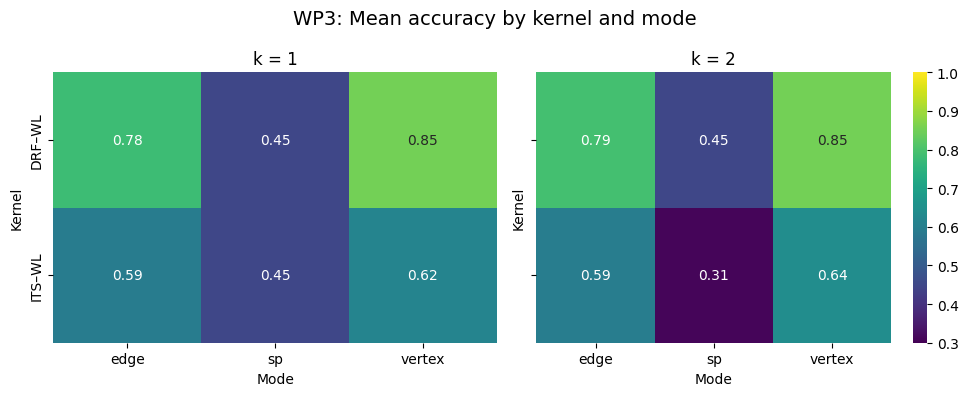

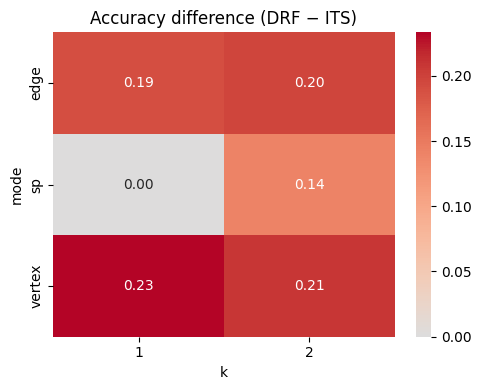

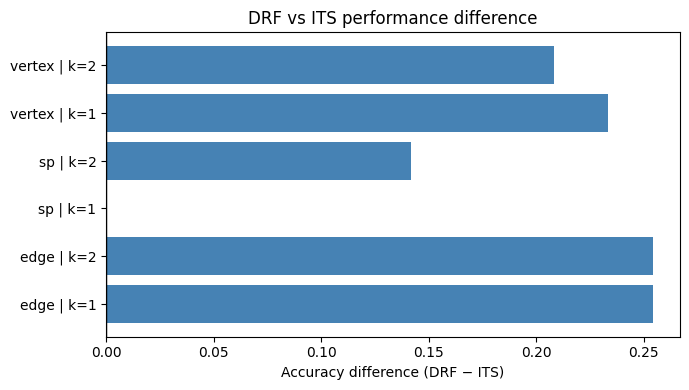

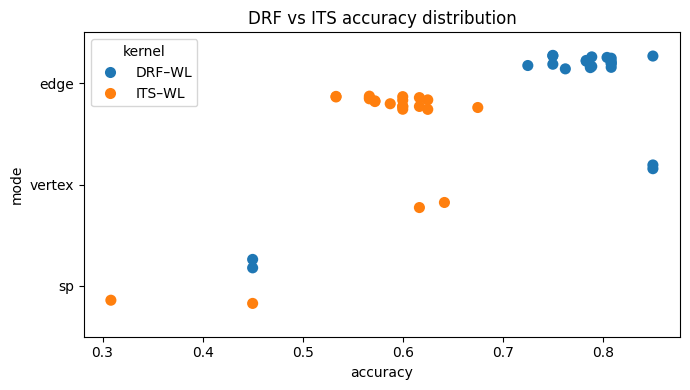

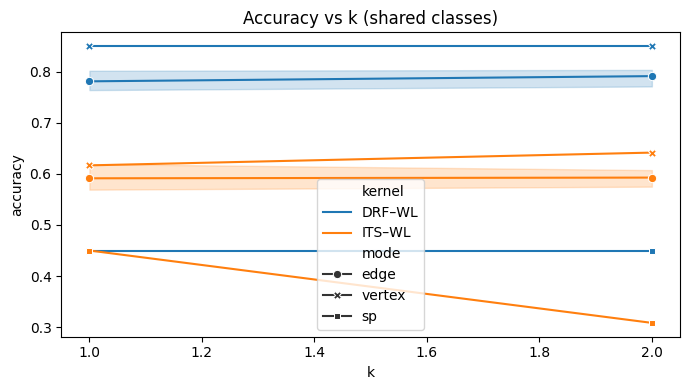

In [13]:
figs = quick_summary_and_dashboard(df_results, title_prefix="WP3 (k=1 vs k=2)")

# Dashboard-Hauptfiguren anzeigen
for key, fig in figs.items():
    print("Showing:", key)
    fig.show()

# Zusätzliche Plots
plot_heatmaps_by_k(df_results)
plot_difference_heatmap(df_results)
plot_drf_minus_its_bar(df_results)
plot_drf_vs_its_dots(df_results)
plot_accuracy_by_k(df_results)


## Fig-2-Style SVM aus Kernel (DRF–WL edge, n=200)

In [14]:
# Nutzt K_drf und y_drf_small aus dem Kernel-Block oben
fig, info = fig2_style_svm_from_kernel(
    K_drf,
    y_drf_small,
    C=1.0,
    n_points_grid=250,
    seed=42,
    title=f"DRF–WL edge | Fig-2 style (n={K_drf.shape[0]})"
)
print(info)
fig.show()


{'class_a': np.str_('6.2.1'), 'class_b': np.str_('1.7.4'), 'n_samples': 90}


In [15]:
# 1) Ein paar reale Paare nehmen und die mittlere Zeit eines Kernelaufrufs messen
import time, numpy as np
from scripts.wp3.wp3_kernel import kernel_multiset_intersection

# nimm ein paar Reaktionen aus deinen bereits geladenen Features, z. B. X_drf["edge"]
pairs = []
X_samp = X_drf["edge"][:200]  # oder X_its["edge"]
for i in range(0, min(200, len(X_samp))-1, 10):
    pairs.append((X_samp[i], X_samp[i+1]))

# Warmup
for a,b in pairs[:5]:
    _ = kernel_multiset_intersection(a,b)

t0 = time.perf_counter()
N = 200
for _ in range(N):
    a,b = pairs[_ % len(pairs)]
    _ = kernel_multiset_intersection(a,b)
t1 = time.perf_counter()
t_per_call = (t1 - t0) / N
print(f"≈ {t_per_call*1e6:.1f} µs pro Kernelaufruf")

# 2) Abschätzen für gewünschtes n und test_size
def estimate_runtime_seconds(n, test_size=0.2, t_call=t_per_call):
    n_train = int(round(n * (1 - test_size)))
    n_test  = n - n_train
    n_calls = n_train*n_train + n_test*n_train
    return n_calls * t_call

for n in [200, 500, 600, 1200]:
    est = estimate_runtime_seconds(n)
    print(f"n={n}: ~{est:.1f} s ({est/60:.1f} min)")

≈ 5.0 µs pro Kernelaufruf
n=200: ~0.2 s (0.0 min)
n=500: ~1.0 s (0.0 min)
n=600: ~1.4 s (0.0 min)
n=1200: ~5.8 s (0.1 min)


In [16]:

per_class_target = 200 

res_drf, res_its, cfg_quota = prepare_quota_dataset_and_train(
    drf_edge_dir=DRF_DIRS["edge"],
    its_edge_dir=ITS_DIRS["edge"],
    per_class_target=per_class_target,
    max_per_class=1000,
    test_size=0.2,
    C=1.0,
    seed=42,
    verbose=True,
)

print("DRF acc:", res_drf.acc)
print("ITS acc:", res_its.acc)
print("Used subsets:", cfg_quota["subset_ids"][:10], "..." if len(cfg_quota["subset_ids"])>10 else "")
print("Remaining deficits (if any):", {k: v for k, v in cfg_quota["deficits"].items() if v > 0})

Quota config: opt_quota_all_classes_169subs
n_subsets: 169
deficits (remaining): {}
SVM (precomputed kernel) | n=10000 | test_size=0.2 | C=1.0
Accuracy: 0.7985
              precision    recall  f1-score   support

       1.2.1       1.00      0.95      0.97        40
       1.2.4       0.83      0.97      0.90        40
       1.2.5       1.00      0.97      0.99        40
       1.3.6       0.57      0.65      0.60        40
       1.3.7       0.68      0.65      0.67        40
       1.3.8       0.82      0.68      0.74        40
       1.6.2       0.62      0.38      0.47        40
       1.6.4       0.71      0.50      0.59        40
       1.6.8       0.67      0.72      0.70        40
       1.7.4       0.98      1.00      0.99        40
       1.7.6       0.62      0.85      0.72        40
       1.7.7       0.72      0.72      0.72        40
       1.7.9       0.78      0.70      0.74        40
       1.8.5       1.00      0.95      0.97        40
      10.1.1       0.61      